# Classification with Kernel Fisher Discriminant

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Assignment 1 (due: Monday, 20 April, 23:59)

Name: Zhuang Li

Student ID: u5391572

## Instructions

|             |Notes|
|:------------|:--|
|Maximum marks| 20|
|Weight|20% of final grade|
|Format| Complete this ipython notebook. Do not forget to fill in your name and student ID above|
|Submission mode| Use [wattle](https://wattle.anu.edu.au/)|
|Formulas| All formulas which you derive need to be explained unless you use very common mathematical facts. Picture yourself as explaining your arguments to somebody who is just learning about your assignment. With other words, do not assume that the person marking your assignment knows all the background and therefore you can just write down the formulas without any explanation. It is your task to convince the reader that you know what you are doing when you derive an argument.|
| Code quality | Python code should be well structured, use meaningful identifiers for variables and subroutines, and provide sufficient comments. Please refer to the examples given in the tutorials. |
| Code efficiency | An efficient implementation of an algorithm uses fast subroutines provided by the language or additional libraries. For the purpose of implementing Machine Learning algorithms in this course, that means using the appropriate data structures provided by Python and in numpy/scipy (e.g. Linear Algebra and random generators). |
| Late penalty | For every day (starts at midnight) after the deadline of an assignment, the mark will be reduced by 5%. No assignments shall be accepted if it is later than 10 days. | 
| Coorperation | All assignments must be done individually. Cheating and plagiarism will be dealt with in accordance with University procedures (please see the ANU policies on [Academic Honesty and Plagiarism](http://academichonesty.anu.edu.au)). Hence, for example, code for programming assignments must not be developed in groups, nor should code be shared. You are encouraged to broadly discuss ideas, approaches and techniques with a few other students, but not at a level of detail where specific solutions or implementation issues are described by anyone. If you choose to consult with other students, you will include the names of your discussion partners for each solution. If you have any questions on this, please ask the lecturer before you act. |
| Solution | To be presented in the tutorials. |

$\newcommand{\dotprod}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\onevec}{\mathbb{1}}$

Setting up the environment

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import scipy
%matplotlib inline

## The data set

We will use census data from the [Australian Bureau of Statistics](http://www.abs.gov.au/). The table, which you can [download here](https://sml.forge.nicta.com.au/isml15/data/census_abs2011_summary.csv), contains a set of median and mean values for different regions of Australia.
*(optional information, for interest only) The data consists of values from 2011 of Statistical Areas Level 3 (SA3s) which are often functional areas of regional citeis and large urban transport and service hubs. In general they have populations between 30,000 and 130,000 persons. For details, look at the [source at ABS](http://www.abs.gov.au/websitedbs/censushome.nsf/home/data?opendocument&navpos=200).*

The following code reads in the data using pandas.

In [3]:
raw_data = pd.read_csv('census_abs2011_summary.csv')
print(raw_data.shape)
raw_data.head()

(342, 8)


,Median_age_of_persons_Census_year_2011,Median_mortgage_repayment_monthly_Census_year_2011,Median_rent_weekly_Census_year_2011,Median_total_family_income_weekly_Census_year_2011,Median_total_household_income_weekly_Census_year_2011,Median_total_personal_income_weekly_Census_year_2011,Average_household_size_Census_year_2011,Average_number_of_persons_per_bedroom_Census_year_2011
0,41,1517,180,1307,1015,533,2.5,1.1
1,37,2045,280,2069,1679,830,2.6,1.1
2,38,1300,200,1256,1033,642,2.3,1.1
3,49,1304,209,972,815,438,2.3,1.1
4,41,1950,280,1395,1087,529,2.5,1.1


## (2 points) Plot some characteristics of the data

Display the following two summaries of the data. Please label all the axes, and title the plots appropriately.
* Plot the median monthly mortgage repayment (horizontal axis) to the median weekly rent (vertical axis)
* Plot the histogram of the median age. Use bin boundaries [0,20,30,35,40,45,50,60,80]

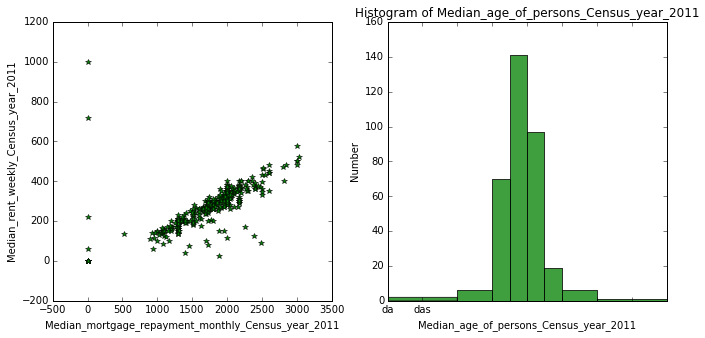

In [4]:
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(121)
ax.plot(raw_data['Median_mortgage_repayment_monthly_Census_year_2011'],raw_data['Median_rent_weekly_Census_year_2011'],'g*')
ax.set_xlim(-500,3500)
ax.set_ylim(-200,1200)
ax.set_xlabel('Median_mortgage_repayment_monthly_Census_year_2011')
ax.set_ylabel('Median_rent_weekly_Census_year_2011')
ax = fig.add_subplot(122)
bin_bon=[0,20,30,35,40,45,50,60,80]
ax.hist(raw_data['Median_age_of_persons_Census_year_2011'], bin_bon, facecolor='g', alpha=0.75)
ax.set_xlabel('Median_age_of_persons_Census_year_2011')
ax.set_ylabel('Number')
ax.set_title('Histogram of Median_age_of_persons_Census_year_2011')

The binary classification task under consideration is to predict from the other features, whether the median age in a region is 38 or older.

In [231]:
labelvec = np.array(raw_data['Median_age_of_persons_Census_year_2011'])
y = np.ones(len(labelvec))
neg = labelvec < 38

y[neg] = -1
num_pos = len(np.flatnonzero(y > 0))
num_neg = len(np.flatnonzero(y < 0))
print('Number of positive/negative examples = %d/%d' % (num_pos, num_neg))
headers = list(raw_data.columns.values)
headers.remove('Median_age_of_persons_Census_year_2011')
raw_feat = np.array(raw_data[headers])

avg = np.mean(raw_feat,axis=0)
std_dev = np.std(raw_feat,axis=0)
X = (raw_feat-avg)/std_dev
X.shape

Number of positive/negative examples = 187/155


(342, 7)

## (3 points) Classification via Fisher's Linear Discriminant

Consider the problem of binary classification. Fisher's criterion is given by:
$$
J(w) = \frac{w^T S_B w}{w^T S_W w}
$$
where $S_B$ is the between class covariance and $S_W$ is the within class covariance.

When implementing this as a linear classifier, you need to choose a threshold in projection space. Describe your criteria for choosing a threshold, and justify why it is a good one.

### Solution description
I chose the threshold as: 
$$
c=(P(C_1)\cdot{\mathbf{w}^T\mathbf{m}_1}+P(C_2)\cdot{\mathbf{w}^T\mathbf{m}_2})
$$
Assuming the projected data points in two classes are normally distributed with mean $u_1$ and $u_2$ ($\mathbf{w}^T\mathbf{m}_1$ and $\mathbf{w}^T\mathbf{m}_2$) and covariance $\sigma_1^2$ and $\sigma_2^2$. And we assume the prior distributions for two classes are $P(C_1)$ and $P(C_2)$. So the posterior probabilities are $P(C_1)\cdot{N(u_1,\sigma_1)}$ and $P(C_2)\cdot{N(u_2,\sigma_2)}$. When the projected data points lie on the threshold, the two posterior probabilities should be equal. 
$$
P(C_1)\cdot{N(\frac{c-u_1}{\sigma_1})}=P(C_2)\cdot{N(\frac{c-u_2}{\sigma_2})}
$$
Then if we can assume the covariance of data points in two classes are equal. So we can get a good heuristic solution. 
$$
c=(P(C_1)\cdot{\mathbf{w}^T\mathbf{m}_1}+P(C_2)\cdot{\mathbf{w}^T\mathbf{m}_2})
$$
Reference:
http://stats.stackexchange.com/questions/4942/threshold-for-fisher-linear-classifier

Implement two functions ```train_fld``` and ```predict_fld``` that corresponds to training and prediction. The functions should be used as in the following cell.

In [237]:
"""
calculate m1,m2
M1_Matrix -- data points with positive labels
M2_Matrix -- data points with negative labels
"""
def M1M2(M1_Matrix,M2_Matrix):
    n_m1=M1_Matrix.shape[0]
    n_m2=M2_Matrix.shape[0]
    m1=np.mean(M1_Matrix,axis=0)
    m2=np.mean(M2_Matrix,axis=0)
    return m1,m2,n_m1,n_m2
"""
seperate data with positive and negative labels
Matrix -- data points here (can also be the feature vectors)
y -- labels
"""
def SeparatePosAndNeg(Matrix,y):
    pos_idx=np.where(y==1)
    neg_idx=np.where(y==-1)
    M1_Matrix=Matrix[pos_idx]
    M2_Matrix=Matrix[neg_idx]
    return M1_Matrix,M2_Matrix     
"""
calculate Sw
m1 -- the projected mean of class one
m2 -- the projected mean of class two
M1_Matrix -- data points with positive labels
M2_Matrix -- data points with negative labels
"""
def sW(m1,m2,X,M1_Matrix,M2_Matrix):
    s1_cov=np.cov(M1_Matrix.T)
    s2_cov=np.cov(M2_Matrix.T)
    s1=s1_cov*(M1_Matrix.shape[0]-1)
    s2=s2_cov*(M2_Matrix.shape[0]-1)
    sw=s1+s2
    return sw
"""
training model
X -- training data
y -- training labels
"""
def train_fld(X,y):
    X=np.matrix(X)
    M1_Matrix,M2_Matrix=SeparatePosAndNeg(X,y)
    m1,m2,n_m1,n_m2=M1M2(M1_Matrix,M2_Matrix)
    sw=sW(m1,m2,X,M1_Matrix,M2_Matrix)
    w=np.dot(np.linalg.inv(sw),(m2.T-m1.T))
    c=(np.dot(m1,w)*n_m1/len(X)+np.dot(m2,w)*n_m2/len(X))
    return (w,c)
"""
predict the result
w -- the parameter vector
c -- the threshold
X -- testing data 
y -- test labels
"""
def predict_fld(w,c,X,y):
    pred=np.dot(X,w)
    neg_num=np.where(pred>c)
    pos_num=np.where(pred<=c)
    pred[neg_num]=-1
    pred[pos_num]=1
    # since there is no asking about the error analysis in this part so I commented out the accuracy calculation
    # around accuracy is 0.73
    """
    i=0
    tp=0
    fp=0
    tn=0;
    fn=0;
    assert len(pred) == len(y)
    for num in y:
        if pred[i]==1:
            if pred[i]==int(num):
                tp+=1
            else:
                fp+=1
        if pred[i]==-1:
            if pred[i]==int(num):
                tn+=1
            else:
                fn+=1
        i+=1
    print float(tp+tn)/float(tp+fp+tn+fn)
    """
    return pred
"""
plot the result
"""
def plotResult(w,pred,y):
    max_feature=np.argmax(np.abs(w))
    plt.plot(X[:,max_feature],pred,'b*',label='predicted')
    plt.plot(X[:,max_feature],y,'r*',label='true')
    plt.xlabel('max_feature in data')
    plt.ylabel('predicted_value')
    plt.ylim((-1.1,1.1))

0.74269005848


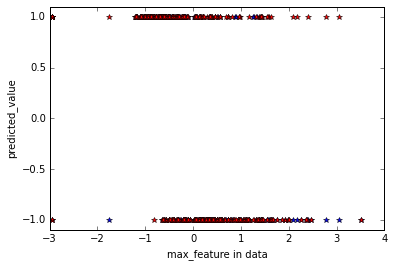

In [238]:
"""
here we just use the whole data points as the training data meanwhile the testing data
"""
w,c = train_fld(X,y)
pred = predict_fld(w,c,X,y)
plotResult(w,pred,y)

## (4 points) Kernels

Recall and write down the definitions corresponding to the Gaussian kernel and the inhomogenous polynomial kernel. Please be precise about the meaning of each symbol *(1 point)*.

### Solution description
GaussianKernel:
\begin{align*}
K(x,x')&=exp(-\frac{||x-x'||^2}{2\sigma^2})\\
(\sigma &>0)
\end{align*}
$x$ and $x'$ ($x'$ doesn't mean the transpose of x) are the vectors in the input space. $\sigma$ is the standard deviation. It determines the width of this kernel. And its square is called the variance.

PolynomialKernel:
$$
K(x,x')=(x^Tx'+c)^d
$$
$x$ and $x'$ are the vectors in the input space. c is "a constant trading off the influence of higher-order versus lower-order terms in the polynomial"(wikipedia). d is the order(degree).

Implement two functions corresponding to the kernels above *(2 points)*.

Gaussian Kernel Matrix:
[[  1.00000000e+00   2.66892123e-02   7.72404607e-01 ...,   1.46643637e-02
    7.75070645e-03   2.06825483e-24]
 [  2.66892123e-02   1.00000000e+00   2.93306194e-02 ...,   2.30354982e-04
    2.40291875e-05   5.51708447e-29]
 [  7.72404607e-01   2.93306194e-02   1.00000000e+00 ...,   1.07355958e-02
    1.47418440e-02   1.60155518e-23]
 ..., 
 [  1.46643637e-02   2.30354982e-04   1.07355958e-02 ...,   1.00000000e+00
    1.88653751e-01   1.02673137e-30]
 [  7.75070645e-03   2.40291875e-05   1.47418440e-02 ...,   1.88653751e-01
    1.00000000e+00   7.55227473e-30]
 [  2.06825483e-24   5.51708447e-29   1.60155518e-23 ...,   1.02673137e-30
    7.55227473e-30   1.00000000e+00]]
Polynomial Kernel Matrix with c=1 of order 2:
[[  5.26361737e+00   4.65239827e-01   4.50313445e+00 ...,   8.23384929e+00
    1.52514111e+01   9.28571009e-02]
 [  4.65239827e-01   2.61165214e+01   1.82853737e-01 ...,   5.59869668e-01
    2.80861962e+00   1.21675083e+02]
 [  4.50313445e+00   1.828

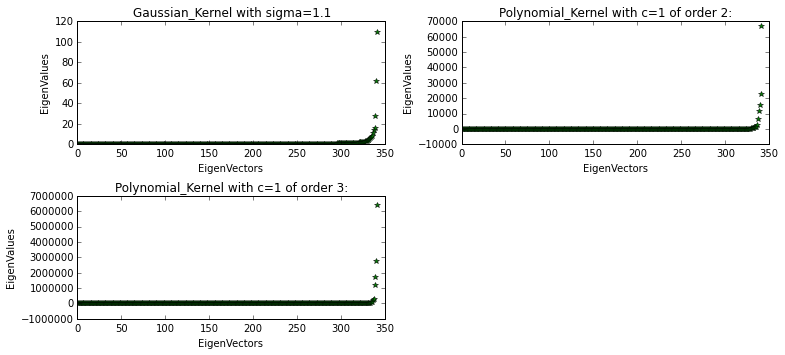

In [285]:
"""
implement Gaussian kernel function
x,z -- data points from input space
sigma -- standard deviation
"""
def Gaussian(x,z,sigma):
    return np.exp((-(np.linalg.norm(x-z)**2))/(2*sigma**2))
"""
implement Polynomial kernel function
x,z -- data points from input space
c -- constant
d -- degree
"""
def Polynomial(x,z,c,d):
    return (np.dot(x.T,z)+c)**d
"""
get Gaussian kernel
X -- data matrix 
sigma -- standard deviation
"""
def GaussianMatrix(X,sigma):
    # to improve the calculation efficiency we use scipy lib but not calculate manually
    dists = squareform(pdist(X, 'euclidean'))
    GassMatrix = scipy.exp(-dists ** 2 / (2*(sigma ** 2)))
    return GassMatrix
"""
get Polynomial kernel
X -- data matrix 
c -- constant
d -- degree
"""
def PolynomialKernel(X,c,d):
    inerpro=np.dot(X,X.T)
    return (inerpro+c)**d
"""
plot Eigen values of three kernel matrix
"""
def plotEigen(GassMatrix,PolyMatrixTwo,PolyMatrixThree):
    # I use 'eigh' because it seems using 'eig' will cause some round problems
    GassEngv,v_GassEngv=np.linalg.eigh(GassMatrix)
    PolyMatrixTwoEngv,v_PolyMatrixTwoEngv=np.linalg.eigh(PolyMatrixTwo)
    PolyMatrixThreeEngv,v_PolyMatrixThreeEngv=np.linalg.eigh(PolyMatrixThree)
    fig = plt.figure(figsize=(11,5))
    ax = fig.add_subplot(221)
    ax.plot(GassEngv,'g*')
    ax.set_title('Gaussian_Kernel with sigma=1.1')
    ax.set_xlabel('EigenVectors')
    ax.set_ylabel('EigenValues')
    ax = fig.add_subplot(222)
    ax.plot(PolyMatrixTwoEngv,'g*')
    ax.set_title('Polynomial_Kernel with c=1 of order 2:')
    ax.set_xlabel('EigenVectors')
    ax.set_ylabel('EigenValues')
    ax = fig.add_subplot(223)
    ax.plot(PolyMatrixThreeEngv,'g*')
    ax.set_title('Polynomial_Kernel with c=1 of order 3:')
    ax.set_xlabel('EigenVectors')
    ax.set_ylabel('EigenValues')
    fig.tight_layout()
GassMatrix=GaussianMatrix(X,1.1)
PolyMatrixTwo=PolynomialKernel(X,1,2)
PolyMatrixThree=PolynomialKernel(X,1,3)
plotEigen(GassMatrix,PolyMatrixTwo,PolyMatrixThree)
print ("Gaussian Kernel Matrix:")
print GassMatrix
print ("Polynomial Kernel Matrix with c=1 of order 2:")
print PolyMatrixTwo
print ("Polynomial Kernel Matrix with c=1 of order 3:")
print PolyMatrixThree

Compute the kernel matrix on all the examples above, and plot the eigenvalues of the kernel matrix. Show results for the Gaussian kernel with width $\sigma=1.1$ and the polynomial kernel with $c=1$ of order 2 and 3 *(1 point)*.

## (4 points) Normalisation in using kernels

You have seen the importance of normalisation in the tutorials.

In the following, we use the fact that kernels ($k(\cdot, \cdot)$) are inner products in a feature space with feature mapping $\phi(\cdot)$:
$$k(x,y) = \dotprod{\phi(x)}{\phi(y)}$$

### Centering

Centering causes the mean of the data set to be the zero vector in feature space. The following is a derivation for doing the centering directly using kernels.

$$
\mu = \frac{1}{n}\sum_{i=1}^n \phi(x_i)
$$
then
$$
\hat{\phi}(x) = \phi(x) - \mu.
$$
Hence
\begin{align*}
\hat{k}(x,y) &= \dotprod{\hat{\phi}(x)}{\hat{\phi}(y)}\\
    &= \dotprod{\phi(x) - \mu}{\phi(y) - \mu}
\end{align*}

Justify and explain the above steps.

### Solution description
Explain each steps:

$\mu$ is the mean of the feature vectors in the feature space.

$\hat{\phi}(x)$ is the new vector center point of which is the $\mu$ instead of its original center. So the feature vectors would be symmetric to the original point.

$\hat{k}(x,y)$ is the inner product of the centered vectors.

Then we can get the deviation:

$$
\begin{align}
<\hat{\phi}(x),\hat{\phi}(y)>
&= <\phi(x)-\mu ,\phi(y)-\mu>\\
&= (\phi(x)-\mu)^T(\phi(y)-\mu)\\
&= \phi(x)^T\phi(y)-\mu^T\phi(y)-\phi(x)^T\mu+\mu^T\mu\\
\end{align}
$$

We can construct a kernel.

$\hat{\mathbf{K}} = \mathbf{K} - \mathbf{J} - \mathbf{J}^T + \mathbf{E}$

$\mathbf{J} = \frac{1}{n}\onevec^T\onevec\mathbf{K}$

$\mathbf{E} = \frac{1}{n^2}(\onevec\mathbf{K}\onevec^T)\onevec^T\onevec$

where:

$\onevec \in 1 \times N$

$N$ is the dimension of the uncentered kernel $\mathbf{K}$.

Reference: "Kernel Methods for Pattern Analysis"(John Shawe-Taylor and Nello Cristianini) chapter 5

### Unit diagonal

It is often convenient to have all the examples to be represented by vectors of the same length. This implies that the diagonal of the kernel matrix (the squared length) is the same for all examples. We arbitrarily (without loss of generality) set this length to 1.
\begin{align*}
\hat{k}(x,y) &= \dotprod{\frac{\phi(x)}{\|\phi(x)\|}}{\frac{\phi(y)}{\|\phi(y)\|}}\\
    &= \frac{1}{\|\phi(x)\|\|\phi(y)\|}\dotprod{\phi(x)}{\phi(y)}\\
    &= \frac{1}{\|\phi(x)\|\|\phi(y)\|} k(x,y)
\end{align*}

Normalizing the kernel matrix such that it has one along the diagonal is sometimes called trace normalisation or spherical normalisation.

Justify and explain each step of the derivation above.


### Solution description
Explain each step:

$$
\begin{align*}
\|\phi(x)\|&= \sqrt{\left \| \phi(x) \right \|^2} \\
&= \sqrt{ \left \langle \phi(x) ,\phi(x)  \right \rangle} \\
&= \sqrt{k(x,x)}
\end{align*}
$$

So

$$
\begin{align*}
\dotprod{\frac{\phi(x)}{\|\phi(x)\|}}{\frac{\phi(y)}{\|\phi(y)\|}}&= \frac{1}{\|\phi(x)\|\|\phi(y)\|} k(x,y)\\
&= \frac{k(x,y)}{\sqrt{k(x,x)}\sqrt{k(y,y)}}
\end{align*}
$$

From the deviation, we can see the length of all the feature vectors would be one. So the diagonal of the unit kernel would be one.

From the equation above we can construct a new kernel $\hat{\mathbf{K}}=\mathbf{D}\mathbf{K}\mathbf{D}$

where:

$ \hat{\mathbf{K}}=
\begin{bmatrix}
\frac{k(x_1,x_1)}{\sqrt{k(x_1,x_1)}\sqrt{k(x_1,x_1)}}& ... & \frac{k(x_1,x_n)}{\sqrt{k(x_1,x_1)}\sqrt{k(x_n,x_n)}}\\
.\\.\\
\frac{k(x_n,x_1)}{\sqrt{k(x_n,x_n)}\sqrt{k(x_1,x_1)}}& ... & \frac{k(x_n,x_n)}{\sqrt{k(x_n,x_n)}\sqrt{k(x_n,x_n)}}\\ 
\end{bmatrix}
$
$ \mathbf{D}=
\begin{bmatrix}
\frac{1}{\sqrt{k(x_1,x_1)}}& 0 &0& ... & 0\\
0& \frac{1}{\sqrt{k(x_2,x_2)}}&0& ... & 0\\
.\\.\\
0& 0&0& ... & \frac{1}{\sqrt{k(x_n,x_n)}}\\ 
\end{bmatrix}
$

$\mathbf{K}$ is the ununited kernel.

Reference: "Kernel Methods for Pattern Analysis"(John Shawe-Taylor and Nello Cristianini) chapter 5

In [286]:
"""
Centering

kernelMatrix -- kernel matrix to be centered
return the centered kernel
"""
def CenterKernelMatrix(kernelMatrix):
    D=len(kernelMatrix)
    rowmean=np.mean(kernelMatrix,axis=0)
    rowmean=np.matrix(rowmean)
    mean=np.mean(rowmean)
    J=np.dot(np.ones((D,1)),rowmean)
    centerKernelMatrix=kernelMatrix-J-J.T+mean*np.ones((D,D))
    return centerKernelMatrix
"""
Unit diagonal

kernelMatrix -- kernel matrix to be united
return the united kernel
"""
def UnitKernelMatrix(kernelMatrix):
    D = np.diag(1.0/np.sqrt(np.diag(kernelMatrix)),k=0)
    return np.dot(D,np.dot(kernelMatrix,D))

## (3 points) Kernelising Fisher's Discriminant

### Definition
Consider a binary classification task.
Recall from the lecture that Fisher's criterion is given by:
$$
J(w) = \frac{(m_2 - m_1)^2}{s_1^2 + s_2^2}
$$
where $m_1$ and $m_2$ are the means of class $\mathcal{C}_1$ and $\mathcal{C}_2$ respectively, and $s_1^2$ and $s_2^2$ are the corresponding within class variances.

Write down the definition of $m_1, m_2, s_1, s_2$ in terms of the examples $\mathbf{x}$ and the labels $y$. Please define all your symbols carefully, in particular $\mathbf{w}$.

### Solution
$$
\mathbf{m}_1=\frac{1}{N_1}\sum_{n\in{C_1}}\mathbf{x}_n
$$
$$
\mathbf{m}_2=\frac{1}{N_2}\sum_{n\in{C_2}}\mathbf{x}_n
$$
$\mathbf{m}_k$ is the mean of the vectors in space of class k. $N_k$ is the number of the data points in class k.
$C_k$ symbolize the set of class k.

$$
m_1=\mathbf{w}^T\mathbf{m}_1
$$
$$
m_2=\mathbf{w}^T\mathbf{m}_2
$$
$m_k$ is the mean of the projected data from $C_k$
$$
s_1^2=\sum_{n\in{C_1}}(y_1-m_1)^2
$$
$$
s_2^2=\sum_{n\in{C_2}}(y_2-m_2)^2
$$
$y_1$ is the labels which are class one and $y_2$ is the labels which are class two.
$$
\mathbf{w} \propto \mathbf{S_W}^{-1} (m_2 - m_1)
$$
$\mathbf{w}$ is a vector proportional to the difference of the class means and in the meantime it is perpendicular to the decision boundary. In fact it is projection vector used to project data from high dimension to one dimension. So we can classify data using the one dimension data.

### Matrix form

Observe that you can express the sum of a set of vectors as a product of a vector of ones, $\onevec$ and a matrix containing the vectors. Define matrices $\mathbf{X}_1$ and $\mathbf{X}_2$ as the data corresponding to class $\mathcal{C}_1$ and $\mathcal{C}_2$ respectively. Please specify the dimensions carefully. Using these definitions, derive the expression for the numerator of $J(w)$, i.e. $(m_2 - m_1)^2$ where the data only appears in terms of the matrices $\mathbf{X}_1\mathbf{X}_1^T$, $\mathbf{X}_1\mathbf{X}_2^T$, $\mathbf{X}_2\mathbf{X}_1^T$ and $\mathbf{X}_2\mathbf{X}_2^T$. There could be other vectors, for example $\mathbf{w}$.

### Solution
We define $\mathbf{X}_k \in R^{M \times N_k}$ and $\onevec_k \in R^{N_k \times 1}$.

$M$ is the dimension of the data vectors. $N_k$ is the number of data points in class $C_k$. $k$ is the mark of class

$\onevec_k$ is a vector of ones.

So we get the mean of the vectors in class space k:

$
\mathbf{m}_1=\frac{1}{N_1}\mathbf{X}_1\onevec_1
$

$
\mathbf{m}_2=\frac{1}{N_2}\mathbf{X}_2\onevec_2
$

Then we can get the projection of mean vectors:

$
m_1=\mathbf{w}^T\mathbf{m}_1
$

$
m_2=\mathbf{w}^T\mathbf{m}_2
$

So, we put all the equations back to the original equation and the last derivation is:
$$
\begin{align}
(m_2-m_1)^2 &= (\frac{1}{N_2}\mathbf{w}^T\mathbf{X}_2\onevec_2-\frac{1}{N_1}\mathbf{w}^T\mathbf{X}_1\onevec_1)^2\\
&=\frac{1}{N_2}\mathbf{w}^T\mathbf{X}_2\onevec_2\frac{1}{N_2}\mathbf{w}^T\mathbf{X}_2\onevec_2+\frac{1}{N_1}\mathbf{w}^T\mathbf{X}_1\onevec_1\frac{1}{N_1}\mathbf{w}^T\mathbf{X}_1\onevec_1-2\frac{1}{N_2}\mathbf{w}^T\mathbf{X}_2\onevec_2\frac{1}{N_1}\mathbf{w}^T\mathbf{X}_1\onevec_1\\
&=\frac{1}{N_2}\mathbf{w}^T\mathbf{X}_2\onevec_2\frac{1}{N_2}((\mathbf{X}_2\onevec_2)^T\mathbf{w})^T+\frac{1}{N_1}\mathbf{w}^T\mathbf{X}_1\onevec_1\frac{1}{N_1}((\mathbf{X}_1\onevec_1)^T\mathbf{w})^T-2\frac{1}{N_2}\mathbf{w}^T\mathbf{X}_2\onevec_2\frac{1}{N_1}((\mathbf{X}_1\onevec_1)^T\mathbf{w})^T\\
&=\frac{1}{N_2}\mathbf{w}^T\mathbf{X}_2\onevec_2\frac{1}{N_2}(\mathbf{X}_2\onevec_2)^T\mathbf{w}+\frac{1}{N_1}\mathbf{w}^T\mathbf{X}_1\onevec_1\frac{1}{N_1}(\mathbf{X}_1\onevec_1)^T\mathbf{w}-2\frac{1}{N_2}\mathbf{w}^T\mathbf{X}_2\onevec_2\frac{1}{N_1}(\mathbf{X}_1\onevec_1)^T\mathbf{w}\\
&=\frac{1}{N_2}\mathbf{w}^T\mathbf{X}_2\onevec_2\frac{1}{N_2}\onevec_2^T\mathbf{X}_2^T\mathbf{w}+\frac{1}{N_1}\mathbf{w}^T\mathbf{X}_1\onevec_1\frac{1}{N_1}\onevec_1^T\mathbf{X}_1^T\mathbf{w}-2\frac{1}{N_2}\mathbf{w}^T\mathbf{X}_2\onevec_2\frac{1}{N_1}\onevec_1^T\mathbf{X}_1^T\mathbf{w}\\
&=\mathbf{w}^T(\frac{1}{N_1^2}\mathbf{X}_1\onevec_1\onevec_1^T\mathbf{X}_1^T+\frac{1}{N_2^2}\mathbf{X}_2\onevec_2\onevec_2^T\mathbf{X}_2^T-\frac{2}{N_1N_2}\mathbf{X}_2\onevec_2\onevec_1^T\mathbf{X}_1^T)\mathbf{w}
\end{align}
$$

Here:

$((\mathbf{X}_2\onevec_2)^T\mathbf{w})^T=(\mathbf{X}_2\onevec_2)^T\mathbf{w}$

because:

$(\mathbf{X}_2\onevec_2)^T\mathbf{w}$ is symmetric.

### Kernel form

The above matrix forms $\mathbf{X}_1\mathbf{X}_1^T$, $\mathbf{X}_1\mathbf{X}_2^T$, $\mathbf{X}_2\mathbf{X}_1^T$ and $\mathbf{X}_2\mathbf{X}_2^T$ can be considered to be the special case of the linear kernel, i.e. $\phi(x) = x$. Observe that the numerator of Fisher's criterion can be expressed purely as inner products between examples. It turns out that the denominator can also be expressed purely as inner products.


Implement Kernel Fisher's Discriminant such that it can take a general kernel function. This is the function of the form:
$$
J(\alpha) = \frac{\alpha M \alpha}{\alpha N \alpha}
$$
where $M$ and $N$ are defined on the following [Wikipedia entry](http://en.wikipedia.org/wiki/Kernel_Fisher_discriminant_analysis).

In [299]:
def meanMatrix(kernelMatrix):
    return np.mean(kernelMatrix,axis=0)
"""
calculate M1 and M2 and separate the kernels

KernelMatrix -- the kernel vectors used to train
y -- labels corresponding to each kernel vector
SeparatePosAndNeg -- function to separate the positive and negative kernel vectors
"""
def M1AndM2(KernelMatrix,y,SeparatePosAndNeg):
    #seperate the kernel matrix with positive labels and negative labels
    M1_Matrix,M2_Matrix=SeparatePosAndNeg(KernelMatrix,y)
    M1=meanMatrix(M1_Matrix)
    M2=meanMatrix(M2_Matrix)
    M1=np.matrix(M1)
    M2=np.matrix(M2)
    return M1,M2,M1_Matrix,M2_Matrix
"""
calculate the M
M1 -- the mean of the positive kernel vectors
M2 -- the mean of the negative kernel vectors
"""
def calM(M1,M2):
    J=M2.T-M1.T
    return np.dot(J,J.T)
"""
calculate N
here to prevent the singular and so a multiple of the identity is added to it and the lamda is 0.1
"""
def calN(M1,M2,M1_Matrix,M2_Matrix):
    D1=len(M1_Matrix)
    D2=len(M2_Matrix)
    N1=np.dot(np.dot(M1_Matrix.T,(np.eye(D1)-1/float(D1))),M1_Matrix)
    N2=np.dot(np.dot(M2_Matrix.T,(np.eye(D2)-1/float(D2))),M2_Matrix)
    D=len(N1)
    return N1+N2+0.1*np.eye(D)
"""
calculate alph
"""
def calAlph(M1,M2,N):
    return np.linalg.inv(N)*(M2.T-M1.T)
"""
Kernel Fisher's Discriminant J(alph)=(alph*M*alph)/(alph*N*alph)
"""
def KFD(alph,M,N):
    return np.dot(np.dot(alph.T,M),alph)/np.dot(np.dot(alph.T,N),alph)
M1,M2,M1_Matrix,M2_Matrix=M1AndM2(GassMatrix,y,SeparatePosAndNeg)
M=calM(M1,M2)
N=calN(M1,M2,M1_Matrix,M2_Matrix)
alph=calAlph(M1,M2,N)
print KFD(alph,M,N)

[[ 0.01545094]]


## (4 points) Comparing performance for different kernels

Use half of the available data for training the model. The rest of the data is allocated to the test set. Repeat the experiment 10 times for different random splits of the data. Report the balanced accuracy for the test sets and plot a boxplot comparing the performance of the five kernel functions: Gaussian kernel with width $\sigma=\{0.23, 1.1, 8.7\}$ and the polynomial kernel with $c=1$ of order 2 and 3. Do not forget to label the graph appropriately.

If you were unable to solve the previous questions on kernelising Fisher's Discriminant and normalisation, report results using Linear Fisher's Discriminant on the 8 features above, and also the polynomial basis of degree 2 from Tutorial 2.

Gaussian Kernel with sigma = 0.23:
[ 0.76753521  0.76046798  0.71419753  0.70256889  0.69051268  0.70666667
  0.71868885  0.70595533  0.75303951  0.69570323]
Gaussian Kernel with sigma = 1.1:
[ 0.77083333  0.78351573  0.75417579  0.75389984  0.76302817  0.75263158
  0.79326513  0.75116951  0.74086538  0.73225108]
Gaussian Kernel with sigma = 8.7:
[ 0.79301075  0.79135802  0.76712798  0.76016484  0.69333333  0.73076923
  0.7447716   0.78939808  0.71344702  0.78899836]
Polynomial kernel with c=1 of order 2:
[ 0.78331053  0.80131579  0.80042433  0.76139818  0.77345679  0.79520833
  0.77105263  0.77088503  0.78398191  0.74052334]
Polynomial kernel with c=1 of order 3:
[ 0.79802817  0.79200334  0.82386364  0.76671733  0.76625     0.77242965
  0.82892573  0.77549296  0.73424226  0.7732038 ]


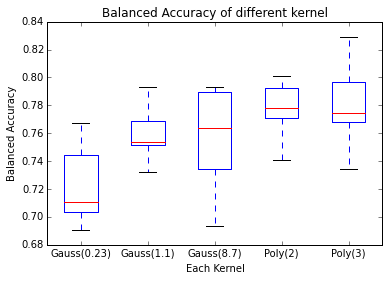

In [309]:
import random
"""
generate the training kernel matrix and the similarity matrix between testing feature vectors and the training vectors 
X -- kernel matrix generated by original data
y -- labels
"""
def TrainAndTestDataGenerator(X,y):
    N = len(X)
    idx = np.arange(N)
    #np.random.seed(1)
    np.random.shuffle(idx)
    train_idx = idx[:int(N/2)]
    test_idx = idx[int(N/2):]
    train_set = X.take(train_idx,axis=0).take(train_idx,axis=1)#generate the kernel used to training
    t_train_set = y[train_idx]
    test_set = X.take(test_idx,axis=0).take(train_idx,axis=1)#generate the kernel used to testing
    t_test_set = y[test_idx]
    return train_set,t_train_set,test_set,t_test_set
"""
get the prediction vectors
alph -- the weight trained from the training data
kernelMatrix -- the kernel vectors used to test
"""
def getPred(alph,kernelMatrix,M1,M2):
    pred = np.ones(kernelMatrix.shape[0])
    dist1 = np.fabs(np.dot(kernelMatrix, alph) - np.dot(M1,alph))#calculate the distance to projected mean of class one 
    dist2 = np.fabs(np.dot(kernelMatrix, alph) - np.dot(M2,alph))#calculate the distance to projected mean of class two 
    dist1=np.asarray(dist1)
    dist2=np.asarray(dist2)
    dist1=dist1.flatten()
    dist2=dist2.flatten()
    # if distance to class one is bigger than to class two then the point belongs to two label of which is -1
    compare=np.asarray(dist1 > dist2) 
    pred[compare] = -1
    return pred
"""
get the elements of the confusion matrix
pred -- the result of prediction
y -- labels 
return the value of true positive,false positive,true negative,false negative
"""
def performance(pred,y):
    i=0
    tp=0
    fp=0
    tn=0;
    fn=0;
    assert len(pred) == len(y)
    for num in y:
        if pred[i]==1:
            if pred[i]==int(num):
                tp+=1
            else:
                fp+=1
        if pred[i]==-1:
            if pred[i]==int(num):
                tn+=1
            else:
                fn+=1
        i+=1
    return tp,fp,tn,fn
"""
get the precision
"""
def precision(tp,fp):
    return tp/float(tp+fp)
"""
get the recall
"""
def recall(tp,fn):
    return float(tp)/float(tp+fn)
"""
get the accuracy
"""
def accuracy(tp,fp,tn,fn):
    return float(tp+tn)/float(tp+fp+tn+fn)
"""
get the banlanced accuracy
"""
def banlanced_accuracy(tp,fp,tn,fn):
    return 0.5*(tp)/float(tp+fn)+0.5*(tn)/float(tn+fp)
"""
calcualte the banlanced accuracy of Gassuian kernel in different sigma

train_set -- the kernel vectors randomly chose from the original kernel matrix used to train a model
t_train_set -- the labels corresponding the train_set kernel vectors
test_set -- the similarity between each test feature vectors and the training feature vectors(it may not be square)
t_test_set -- the labels corresponding the test_set kernel vectors
sigma -- standard deviation
"""
def getGassuianAccuracy(train_set,t_train_set,test_set,t_test_set,sigma):
    M1,M2,M1_Matrix,M2_Matrix=M1AndM2(train_set,t_train_set,SeparatePosAndNeg)
    N=calN(M1,M2,M1_Matrix,M2_Matrix)
    alph=calAlph(M1,M2,N)
    pred=getPred(alph,test_set,M1,M2)
    tp,fp,tn,fn=performance(pred,t_test_set)
    return banlanced_accuracy(tp,fp,tn,fn)
"""
calcualte the banlanced accuracy of Polynomial kernel in different bias and order(degree)

train_set -- the kernel vectors randomly chose from the original kernel matrix used to train a model
t_train_set -- the labels corresponding the train_set kernel vectors
test_set -- the similarity matrix between each test feature vectors and the training feature vectors(it may not be square)
t_test_set -- the labels corresponding the test_set kernel vectors
c -- constant bias
d -- order(degree)
"""
def getPolyAccuracy(train_set,t_train_set,test_set,t_test_set,c,d):
    M1,M2,M1_Matrix,M2_Matrix=M1AndM2(train_set,t_train_set,SeparatePosAndNeg)
    N=calN(M1,M2,M1_Matrix,M2_Matrix)
    alph=calAlph(M1,M2,N)
    pred=getPred(alph,test_set,M1,M2)
    tp,fp,tn,fn=performance(pred,t_test_set)
    return banlanced_accuracy(tp,fp,tn,fn)
"""
get the matrix storing the accuracy of every experiment with different kernels
"""
def getPlotMatrix():
    accuracyMatrix = np.zeros((5,10))
    sigmaVector = np.array([0.23,1.1,8.7])
    c = 1
    OrderVector = np.array([2,3])
    for i in xrange(0,3):
        sigma = sigmaVector[i]
        Gass_raw=GaussianMatrix(X,sigma)# calculate a kernel matrix using all data points
        Gass_unit=UnitKernelMatrix(Gass_raw)#unit diagonal
        Gass=CenterKernelMatrix(Gass_unit)#centering
        for j in xrange(0,10):
            train_set,t_train_set,test_set,t_test_set=TrainAndTestDataGenerator(Gass,y)# get the index of training and test data
            accuracyMatrix[i][j]+=getGassuianAccuracy(train_set,t_train_set,test_set,t_test_set,sigma)
   
    for i in xrange(0,2):
        d = OrderVector[i]
        Poly_raw=PolynomialKernel(X,c,d)# calculate a kernel matrix using all data points
        Poly_unit=UnitKernelMatrix(Poly_raw)#unit diagonal
        Poly=CenterKernelMatrix(Poly_unit)#centering
        for j in xrange(0,10):
            train_set,t_train_set,test_set,t_test_set=TrainAndTestDataGenerator(Poly,y)# get the index of training and test data
            accuracyMatrix[i+3][j]+=getPolyAccuracy(train_set,t_train_set,test_set,t_test_set,c,d)
    return accuracyMatrix
"""
do the box plot with the accuracy values stored in the accuracyMatrix
"""
def plotTenTimes(accuracyMatrix):
    length = accuracyMatrix.shape[1]
    Gass_1 = accuracyMatrix[0].reshape(length)
    Gass_2 = accuracyMatrix[1].reshape(length)
    Gass_3 = accuracyMatrix[2].reshape(length)
    
    Poly_1 = accuracyMatrix[3].reshape(length)
    Poly_2= accuracyMatrix[4].reshape(length)
    
    plotmatrix=accuracyMatrix.T
    label=['Gauss(0.23)','Gauss(1.1)','Gauss(8.7)','Poly(2)','Poly(3)']
    plt.boxplot(plotmatrix,labels=label)
    print ('Gaussian Kernel with sigma = 0.23:\n'),Gass_1
    print ('Gaussian Kernel with sigma = 1.1:\n'),Gass_2
    print ('Gaussian Kernel with sigma = 8.7:\n'),Gass_3
    print ('Polynomial kernel with c=1 of order 2:\n'),Poly_1
    print ('Polynomial kernel with c=1 of order 3:\n'),Poly_2
    plt.title('Balanced Accuracy of different kernel')
    plt.xlabel('Each Kernel')
    plt.ylabel('Balanced Accuracy')
    plt.show()
"""
run the methods
"""
accuracyMatrix=getPlotMatrix()
plotTenTimes(accuracyMatrix)

        